<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Diss Mere
This notebook has been based off the example of Crystal Correlations - included in the PyleoClim Paper.

In this notebook, we investigate the decadally average record of varve width from Diss Mere. We then compare it to the AMOC in the TraCE simulation. 


## Table of Contents
* [Data](#data)
* [Data Exploration](#dataexp)
    - [Crystal Cave](#crystal)
    - [Sea-surface temperature](#sst)
* [Pitfall #1: persistence](#persistence)
    - [Null models](#nulls)
    - [Timeseries alignment](#alignment)
* [Pitfall #2: look elsewhere effect](#multiple_hyp)
* [Pitfall #3: age uncertainties](#age_uncert)
* [Conclusion](#conclu)
* [References](#ref)

## <a name='data'>Data</a>

The example uses the speleothem record of [McCabe-Glynn et al. (2013)](https://www.nature.com/articles/ngeo1862) from Crystal Cave, California, in the Sequoia National Forest.  Of interest to us is the $\delta^{18}O$ record, which the authors interpret as reflecting sea-surface temperatures (SST) in the Kuroshio Extension region of the West Pacific. This is a strong claim, given that no mechanistic link is proposed,  and relies entirely on an analysis of correlations between the record and instrumental SST.  

## <a name='dataexp'>Data Exploration</a>
 We start by loading a few useful packages:

In [2]:
import matplotlib.pyplot as plt    
import pyleoclim as pyleo
pyleo.set_style('web')  # set the visual style
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

First we load in the varve record:

Index(['Age BP', 'Varve'], dtype='object')


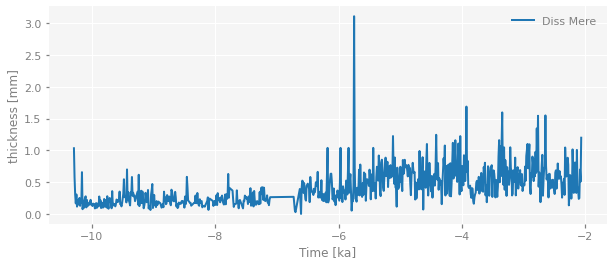

In [17]:
d = pd.read_csv('10_year_varve_thickness.csv')
print(d.columns)
dm = pyleo.Series(time=-d['Age BP']/1000., value=d['Varve'],
                      time_name='Time', time_unit='ka',label='Diss Mere',
                      value_name='thickness', value_unit='mm')
fig, ax = dm.plot()   

Then let's load in the AMOC record from the TraCE simulation

Index(['time (ka BP)', 'maximum AMOC at 52N below 500m (Sv)'], dtype='object')


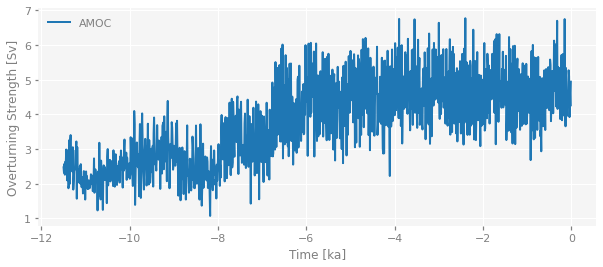

In [18]:
t = pd.read_csv('AMOC_52N_11.5-0kaBP.csv')
print(t.columns)
amoc = pyleo.Series(time=t['time (ka BP)'], value=t['maximum AMOC at 52N below 500m (Sv)'],
                      time_name='Time', time_unit='ka',label='AMOC',
                      value_name='Overturning Strength', value_unit='Sv')
fig, ax = amoc.plot()   

Now we can compute correlations between the two records. 

In [19]:
corr_res = amoc.correlation(dm, seed = 2333)
print(corr_res.r)

0.538585938420973


The correlation is $r=0.539$, and the natural question is: "Is this number significant (i.e. unusual)?" The standard way to assess this is with $t$-test using the test statistic: $$T = \frac{r \sqrt{n-2}}{\sqrt{1-r^2}}$$ (see e.g. Wilks, 2011)  If we plug in the values of $r$ and $n$, we get:  

In [21]:
n = len(dm.time)
nu = n-2
r = corr_res.r
T  = r *np.sqrt(nu)/(np.sqrt(1-r**2))
print("The test statistic is "+ str(T))

The test statistic is 17.423809941462743


Under standard assumptions (the data are independent and identically distributed), $T$ follows Student's $t$ distribution. If we make the same assumption and use the $t$ distribution from SciPy, we can readily compute the p-value (i.e. the probability to observe a test statistic at least as large as this one, under the null distribution):

In [22]:
from scipy.stats import t
pval = 1-t.cdf(T,nu)
print("The p-value is {:10.2e}".format(pval)) # express in exponential notation

The p-value is   0.00e+00


In other words, using the classic test for the significance of correlations "out of the box", one would conclude that the Diss Mere records is unambiguously related to the simualted AMOC. In other words, it looks _rather_ significant. 

However, this test (which is the one that most computing packages, including Excel, implement by default) is not appropriate here, as the theory only applies to data that are independent and indentically distributed ("IID"). Independence means that consecutive observations have no predictive power over each other, which is true neither of the Crystal Cave nor the instrumental target. That is to say: because temperature in one year tends to resemble temperature in the previous or following year (same for $\delta^{18}O$), the data are anything but independent. We will quantify this dependence, and its consequences, below. 

The full result of the Pyleoclim `correlation()` command looks like this:

In [23]:
print(corr_res)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.538586  < 1e-2     True



That is, the correlation value ships with an estimate of the p-value and a boolean flag (True/False) stating whether or not it is below the test level $\alpha$. However, the p-value here is estimated to be 13% (`'p': 0.13`), and therefore the correlation is not deemed significant (`'signif': False`) at the 5% level (`'alpha': 0.05`). How did `pyleoclim` arrive at such a different conclusion than the $2.4 \times 10^{-4}$ seen just above? 

### <a name='nulls'> Null Models</a>

There are in fact 3 ways to make this determination in Pyleoclim. While the standard null model for correlations in the statistical literature is the IID model, we have just seen that it is violated by the persistence of many timeseries, particularly the ones shown above.  The package does implements the classical T-test, but it is adjusted for the loss of degrees of freedom due to persistence as per Dawdy & Matalas (1964):

In [24]:
corr_ttest = amoc.correlation(dm,settings={'method':'ttest'})
print(corr_ttest)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.538586  < 1e-55    True



As a result, the the p-value for the test is now 15%, far above the  $2.4 \times 10^{-4}$ it would be under the IID assumption. 

The next option compares the observed correlation to the distribution of correlations with (by default) 1000 randomly-generated autoregressive (AR(1)) timeseries with the same persistence parameters as the original series, as measured by the lag-1 autocorrelation. This model is parametric, and is named _isopersistent_ because it preserves the persistence properties of each series:

In [25]:
corr_isopersist = amoc.correlation(dm,settings={'method':'isopersistent'}, seed = 2333)
print(corr_isopersist)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.538586  < 1e-6     True



Because this is a simulation-based method, the result will depent on the number of simulations, `nsim`.  Upping `nsim` ensures more consistent results, though in this case the result does not change: 

In [26]:
corr_isopersist = amoc.correlation(dm,settings={'method':'isopersistent','nsim':2000}, seed = 2333)
print(corr_isopersist)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.538586  < 1e-6     True



We see that the p-value changes subtly between these two cases, but not enough to change the result (the correlation is non significant either way). However, to ensure that these sampling issues won't affect the reproducibility of the results, we specify a [random seed](https://en.wikipedia.org/wiki/Random_seed). Note that the difference between “significant” and “not significant” p-values is not itself statistically significant (Gelman & Stern, 2006). 


The last null model method is `isospectral`, which phase-randomizes the original signals, thereby preserving the spectrum of each series but scrambling phase relations between the signals. This (non-paramettric) method was first proposed by Ebisuzaki (1997), and is called _isospectral_ because it leaves the spectrum (and therefore the autocorrelation function) intact. Since, this is also a simulation method, one can also play with the number of simulations, as done here:

In [27]:
corr_isospec = amoc.correlation(dm,settings={'method':'isospectral','nsim':2000}, seed = 4343)
print(corr_isospec)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.538586  < 1e-2     True



We see that this resulted is a modestly different p-value, but again one above 5%, which leads to rejection of the test. 

In this case, the three methods concur that the correlation is insignificant, though we encourage users to play with these methods in case they obtain results close to the test-level, to discourage p-hacking temptations. 


### <a name='alignment'> Timeseries Alignment</a>

As mentioned earlier, the SST and Crystal Cave series are on different time axes, and `Pyleoclim` automated the process of aligning them, doing so under the hood so users can focus on doing science. However, it is useful to understand what is happening and how it can be customized, in case this makes a different to the analysis.  Like other `Pyleoclim` methods designed to compare timeseries,  `correlation()` relies on the `MultipleSeries.common_time()` method for alignment. The method implements three strategies for timeseries alignment:
1. interpolation
1. binning
1. Gaussian kernel smoothing

To explore it, let us first create a `MultipleSeries` object gathering those two series:

(<Figure size 432x288 with 3 Axes>,
 {0: <Axes:ylabel='Overturning Strength [Sv]'>,
  1: <Axes:ylabel='thickness [mm]'>,
  2: <Axes:xlabel='Time [ka]'>})

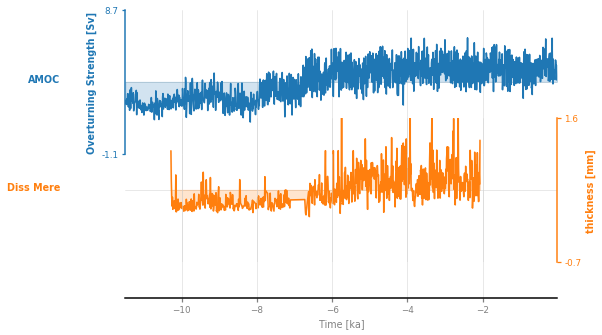

In [28]:
ms = pyleo.MultipleSeries([amoc,dm])
ms.stackplot()

By default, `common_time()` will implement linear interpolation. 

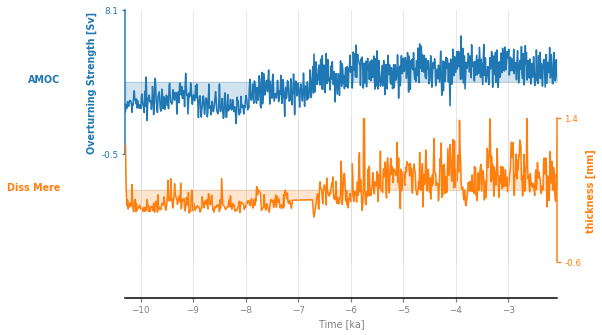

In [29]:
msi = ms.common_time()
fig, ax = msi.stackplot()

It is easy to verify that the two series are indeed on the same axis:

In [30]:
msi.series_list[0].time == msi.series_list[1].time

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

To see how the interpolation changed the original series, we can superimpose the original series as dots on top of this stackplot:

<Axes:ylabel='thickness [mm]'>

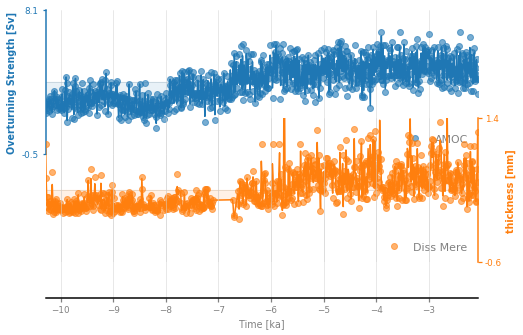

In [33]:
fig, ax = msi.stackplot(labels=None, fill_between_alpha=0.1)
amoc.plot(ax=ax[0],marker='o',linestyle='',xlabel='',alpha=0.6)
dm.plot(ax=ax[1],marker='o',linestyle='',color='C1',xlabel='', alpha=0.6)

We see that interpolation left the Crystal Cave record relatively unchanged, except near the end where resolution is very high. For the HadCRUT4 data, the effect is most noticeable in the 1870s, where there is a gap in data coverage. This could be customized: both the type of interpolation (e.g. linear, quadratic) and the grid step, are customizable (see the [documentation](https://pyleoclim-util.readthedocs.io/en/latest/utils/introduction.html#pyleoclim.utils.tsutils.interp). 

As an example, we could use cubic spline interpoliation, which carries the well-known risk of overfitting, thereby creating unrealistic excursions away from observations:

<Axes:ylabel='SST [C]'>

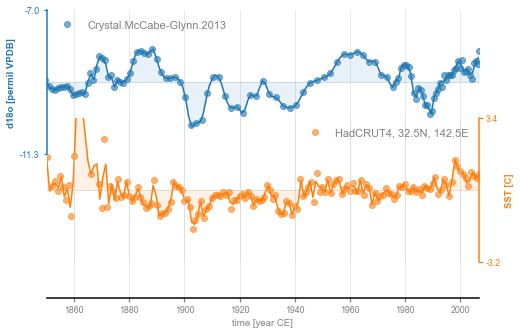

In [23]:
msi = ms.common_time(method='interp',interp_type = 'cubic')
fig, ax = msi.stackplot(labels=None, fill_between_alpha=0.1)
cc.plot(ax=ax[0],marker='o',linestyle='',xlabel='',alpha=0.6)
stts.plot(ax=ax[1],marker='o',linestyle='',color='C1',xlabel='', alpha=0.6)

Another option is [binning](https://pyleoclim-util.readthedocs.io/en/latest/utils/introduction.html#pyleoclim.utils.tsutils.bin), which tends to coarse-grain more, as it will default to the largest time spacing observed in either series to avoid empty bins:

<Axes:ylabel='SST [C]'>

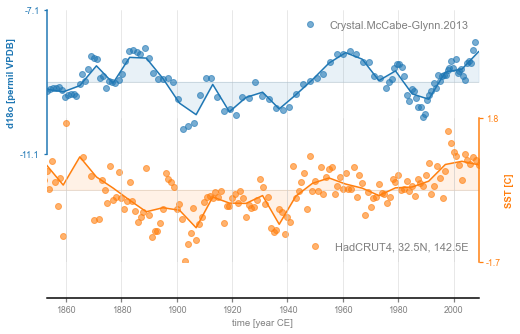

In [24]:
msb = ms.common_time(method='bin')
fig, ax = msb.stackplot(labels=None, fill_between_alpha=0.1)
cc.plot(ax=ax[0],marker='o',linestyle='',xlabel='',alpha=0.6)
stts.plot(ax=ax[1],marker='o',linestyle='',color='C1',xlabel='', alpha=0.6)

Lastly, one may request a gaussian kernel (Rehfeld & Kurths, 2014), which by default uses a bandwidth of 3:

<Axes:ylabel='SST [C]'>

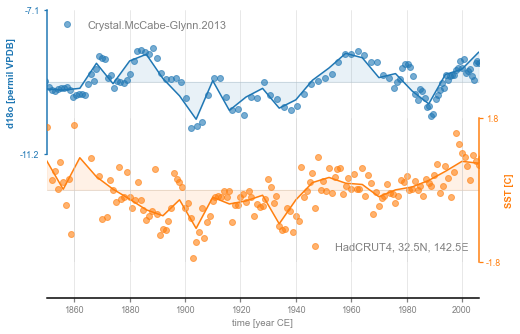

In [45]:
msg = ms.common_time(method='gkernel')
fig, ax = msg.stackplot(labels=None, fill_between_alpha=0.1)
cc.plot(ax=ax[0],marker='o',linestyle='',xlabel='',alpha=0.6)
stts.plot(ax=ax[1],marker='o',linestyle='',color='C1',xlabel='', alpha=0.6)

It is easy to change the bandwidth $h$:

<Axes:ylabel='SST [C]'>

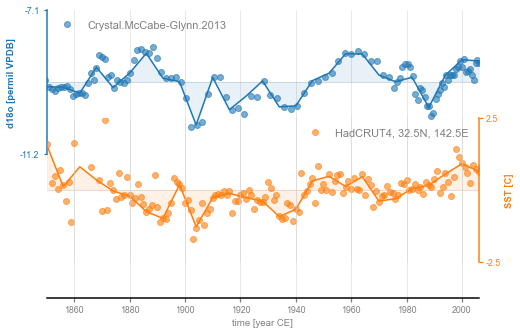

In [46]:
msg = ms.common_time(method='gkernel', h = 0.5)
fig, ax = msg.stackplot(labels=None, fill_between_alpha=0.1)
cc.plot(ax=ax[0],marker='o',linestyle='',xlabel='',alpha=0.6)
stts.plot(ax=ax[1],marker='o',linestyle='',color='C1',xlabel='', alpha=0.6)

The Gaussian kernel method is quite conservative, and typically uses the coarsest possible resolution. 

At the level of correlations, users may specify how they wish to perform this time alignment via the `common_time_kwargs` dictionary, like so:

In [27]:
corr_isospec = stts.correlation(cc,settings={'method':'isospectral','nsim':2000}, 
                                common_time_kwargs = {'method':'interp','interp_type':'cubic'}, seed = 4343)
print(corr_isospec)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.188206       0.36  False



We see that the type of interpolation was somewhat consequential here, lowering the original correlation quite a bit, but this does not change the result. If this low-level task turns out to affect the analysis, it is prudent to take a peak "under the hood" as we did here, and visualize how time series alignment affects the original series. In most instances, however, this should not greatly affect the outcome. 

Note: in the case of the T-test, it would be sufficient to put the timeseries on the same time axis, but that this axis need not be evenly spaced. This is not implemented here. 